In [2]:
from google .colab import drive
drive .mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install biosppy
!pip install heartpy
!pip install neurokit2
!pip install pyampd

# Simulate PPG signal from neurokit2 package

## Spectrum analysis

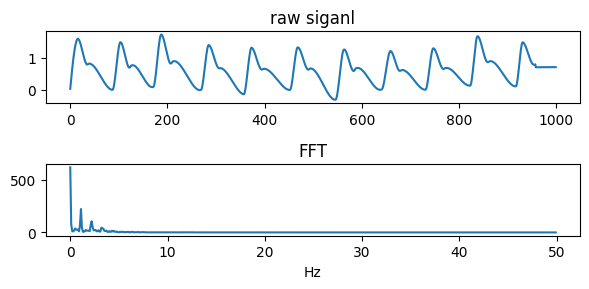

In [8]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
ppg_signal = nk.ppg_simulate(duration=10, sampling_rate=100, heart_rate=70)

# FFT
fs = 100
N = len(ppg_signal)
frequencies = np.fft.fftfreq(N, 1/fs)
fft_values = np.fft.fft(ppg_signal)
single_sided_spectrum = np.abs(fft_values[:N//2])


plt.figure(figsize=(6, 3))
plt.subplot(2, 1, 1)
plt.plot(ppg_signal)
plt.title('raw siganl')

plt.subplot(2, 1, 2)
plt.plot(frequencies[:N//2], single_sided_spectrum)
plt.title('FFT')
plt.xlabel('Hz')

plt.tight_layout()
plt.show()

## Peaks detection

In [9]:
""" This is the package responsible for realizing the ppg pulse normalization.
"""


from sklearn.preprocessing import MinMaxScaler
from pyampd.ampd import find_peaks


def _detect_minimals(signal):
    minimals = find_peaks(-signal)

    return minimals

def _get_central_pulse(signal, minimals):
    n_of_minimals = len(minimals)
    if n_of_minimals < 2:
        central_pulse = np.array([])
        return central_pulse

    central_minimal = int(np.floor(n_of_minimals / 2))
    if n_of_minimals == 2:
        central_minimal = 0

    minimal_after_central = central_minimal + 1

    central_pulse = signal[minimals[central_minimal] : minimals[minimal_after_central]]

    return central_minimal, central_pulse


<function matplotlib.pyplot.legend(*args, **kwargs)>

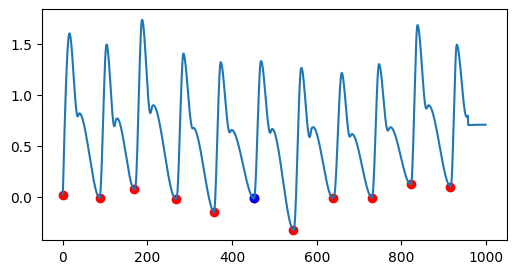

In [11]:

minimals = _detect_minimals(ppg_signal)
central_minimal, central_pulse = _get_central_pulse(ppg_signal, minimals)
plt.figure(figsize=(6, 3))
plt.plot(ppg_signal)
plt.scatter(minimals, ppg_signal[minimals], c="r", label="mini")
plt.scatter(minimals[central_minimal], ppg_signal[minimals[central_minimal]], c="b", label="central mini")
plt.legend

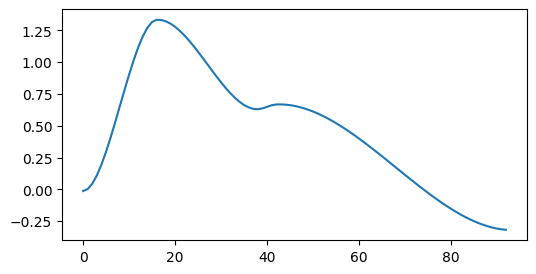

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(central_pulse)

In [16]:
""" This is the package responsible for realizing the photoplethysmogram
pulse key points extraction. """

import numpy as np
import pyampd
import constants as consts


def extract(normalized_pulse):
    is_normalized_pulse_empty = normalized_pulse.size == 0
    if is_normalized_pulse_empty:
        key_points = {}
        return key_points

    # group all key points in this dictionary
    key_points = {
        consts.SYS_PEAK: 0,
        consts.DIAS_PEAK: 0,
    }

    key_points[consts.SYS_PEAK] = _find_systolic_peak_location(normalized_pulse)
    if key_points[consts.SYS_PEAK] == 0:
        key_points = {}
        return key_points

    regular_pulse, pulse_first_derivative, pulse_second_derivative = _fit_section_polynoms(normalized_pulse, key_points[consts.SYS_PEAK])

    key_points[consts.DIAS_PEAK] = _find_diastolic_peak(pulse_first_derivative, pulse_second_derivative, key_points)
    if key_points[consts.DIAS_PEAK] == 0:
        key_points = {}
        return key_points


    return key_points

def _find_systolic_peak_location(normalized_pulse):
    systolic_peak = 0

    max_location = np.where(normalized_pulse == np.max(normalized_pulse))
    max_location_value = max_location[0][0]

    # peaks = pyampd.ampd.find_peaks(normalized_pulse)
    if max_location[0].size == 0:
        return systolic_peak

    systolic_peak = max_location_value

    return systolic_peak

def _fit_section_polynoms(normalized_pulse, systolic_peak):
    pulse_length = len(normalized_pulse)
    up_sampled_rate = 1 / (4*consts.SAMPLING_FREQ)
    pulse_time = np.linspace(0, pulse_length * up_sampled_rate, num = pulse_length, endpoint=False)

    ascending_section, descending_section = _separate_pulse_in_sections(normalized_pulse, systolic_peak)

    ascending_len = len(ascending_section)
    descending_len = len(descending_section)

    # prealocation
    regular_pulse = {
        consts.ASC_POL : np.zeros(consts.ASCENDING_POL_N_OF_COEFS),
        consts.DESC_POL : np.zeros(consts.DESCENDING_POL_N_OF_COEFS),
        consts.ASC_SEC_EVAL : np.zeros(ascending_len),
        consts.DESC_SEC_EVAL : np.zeros(descending_len),
        consts.PULSE_EVAL: np.zeros(ascending_len + descending_len - 1)
    }

    pulse_first_derivative = {
        consts.ASC_POL : np.zeros(consts.ASCENDING_POL_N_OF_COEFS),
        consts.DESC_POL : np.zeros(consts.DESCENDING_POL_N_OF_COEFS),
        consts.ASC_SEC_EVAL : np.zeros(ascending_len),
        consts.DESC_SEC_EVAL : np.zeros(descending_len),
        consts.PULSE_EVAL: np.zeros(ascending_len + descending_len - 1)
    }

    pulse_second_derivative = {
        consts.ASC_POL : np.zeros(consts.ASCENDING_POL_N_OF_COEFS),
        consts.DESC_POL : np.zeros(consts.DESCENDING_POL_N_OF_COEFS),
        consts.ASC_SEC_EVAL : np.zeros(ascending_len),
        consts.DESC_SEC_EVAL : np.zeros(descending_len),
        consts.PULSE_EVAL: np.zeros(ascending_len + descending_len - 1)
    }

    ascending_time = pulse_time[0:systolic_peak + 1]
    descending_time = pulse_time[systolic_peak: len(pulse_time)]

    ###### without derivative ######
    # fit sections polynoms
    regular_pulse[consts.ASC_POL] = np.polyfit(ascending_time, ascending_section, deg=5)
    regular_pulse[consts.DESC_POL] = np.polyfit(descending_time, descending_section, deg=7)
    # evaluate sections polynoms
    regular_pulse[consts.ASC_SEC_EVAL] = np.polyval(regular_pulse[consts.ASC_POL], ascending_time)
    regular_pulse[consts.DESC_SEC_EVAL] = np.polyval(regular_pulse[consts.DESC_POL], descending_time)
    # concatenate sections polynoms
    regular_pulse[consts.PULSE_EVAL] = np.concatenate((regular_pulse[consts.ASC_SEC_EVAL][0:-1], regular_pulse[consts.DESC_SEC_EVAL]))

    ###### first derivative ######
    # fit sections first derivatives polynoms
    pulse_first_derivative[consts.ASC_POL] = np.polyder(regular_pulse[consts.ASC_POL])
    pulse_first_derivative[consts.DESC_POL] = np.polyder(regular_pulse[consts.DESC_POL])
    # evaluate sections first derivatives polynoms
    pulse_first_derivative[consts.ASC_SEC_EVAL] = np.polyval(pulse_first_derivative[consts.ASC_POL], ascending_time)
    pulse_first_derivative[consts.DESC_SEC_EVAL] = np.polyval(pulse_first_derivative[consts.DESC_POL], descending_time)
    # concatenate first derivates sections polynoms
    pulse_first_derivative[consts.PULSE_EVAL] = np.concatenate((pulse_first_derivative[consts.ASC_SEC_EVAL][0:-1], pulse_first_derivative[consts.DESC_SEC_EVAL]))

    ###### second derivative ######
    # fit sections second derivatives polynoms
    pulse_second_derivative[consts.ASC_POL] = np.polyder(pulse_first_derivative[consts.ASC_POL])
    pulse_second_derivative[consts.DESC_POL] = np.polyder(pulse_first_derivative[consts.DESC_POL])
    # evaluate sections second derivatives polynoms
    pulse_second_derivative[consts.ASC_SEC_EVAL] = np.polyval(pulse_second_derivative[consts.ASC_POL], ascending_time)
    pulse_second_derivative[consts.DESC_SEC_EVAL] = np.polyval(pulse_second_derivative[consts.DESC_POL], descending_time)
    # concatenate second derivatives sections polynoms
    pulse_second_derivative[consts.PULSE_EVAL] = np.concatenate((pulse_second_derivative[consts.ASC_SEC_EVAL][0:-1], pulse_second_derivative[consts.DESC_SEC_EVAL]))

    return regular_pulse, pulse_first_derivative, pulse_second_derivative


# todo: change this to receive key_points dict
def _separate_pulse_in_sections(normalized_pulse, systolic_peak):
    ascending_section = normalized_pulse[0 : systolic_peak + 1]
    descending_section = normalized_pulse[systolic_peak: len(normalized_pulse)]

    return ascending_section, descending_section

# We consider the diastolic peak to be the point at which the first
# derivative of the polynomial is equal to zero and the second
# derivative is negative. If there is no such point, then the point
# at which the second derivative is a local minimum is chosen
# as the diastolic peak.
def _find_diastolic_peak(pulse_first_derivative, pulse_second_derivative, key_points):
    diastolic_peak = 0 # always returns 0 if the key point hasn't been detected
    ppg_pulse_second_derivative = pulse_second_derivative[consts.PULSE_EVAL]
    ts = np.round(1/(4*consts.SAMPLING_FREQ), 3)
    t = np.linspace(0, len(ppg_pulse_second_derivative) * ts, num=len(ppg_pulse_second_derivative), endpoint=False)

    if len(ppg_pulse_second_derivative) != len(t):
        return diastolic_peak

    second_derivative_minimals = pyampd.ampd.find_peaks(-ppg_pulse_second_derivative)
    second_derivative_min_after_sys_peak = second_derivative_minimals[second_derivative_minimals > key_points[consts.SYS_PEAK]]

    if len(second_derivative_min_after_sys_peak) > 0:
        # Validate if we should get the first or the last minimal
        diastolic_peak = second_derivative_min_after_sys_peak[0]

    first_derivative_roots = np.roots(pulse_first_derivative[consts.DESC_POL])
    positive_roots = first_derivative_roots[first_derivative_roots > 0]

    is_complex = np.iscomplex(positive_roots)
    if all(is_complex):
        return diastolic_peak

    is_real = np.isreal(positive_roots)
    real_roots = positive_roots[is_real]
    first_real_root = real_roots[0]

    min_root = first_real_root - ts/2
    max_root = first_real_root + ts/2

    is_greater_than_min = t > min_root
    is_less_than_max = t < max_root

    value_index = is_greater_than_min & is_less_than_max
    if not any(value_index):
        return diastolic_peak

    ppg_pulse_second_derivative_at_roots = ppg_pulse_second_derivative[value_index]
    # TO DO: Consider add treatment to when value index has more than one value
    if (ppg_pulse_second_derivative_at_roots[0]) < 0:
        t_at_roots = t[value_index]
        tmp_diastolic_peak = np.where(t == t_at_roots[0])
        diastolic_peak = tmp_diastolic_peak[0][0]
        return diastolic_peak

    return diastolic_peak

<function matplotlib.pyplot.legend(*args, **kwargs)>

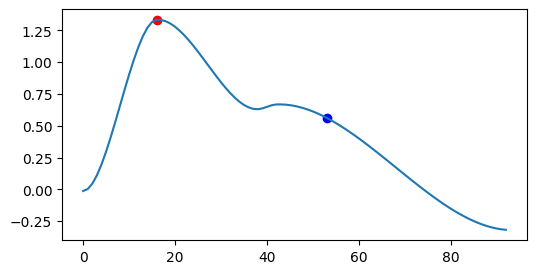

In [18]:
key_points_loc = extract(central_pulse)

S = key_points_loc['systolic peak']
D = key_points_loc['diastolic peak']

plt.figure(figsize=(6, 3))
plt.plot(central_pulse)
plt.scatter(S, central_pulse[S], c="r", label="systolic peaks")
plt.scatter(D, central_pulse[D], c="b", label="diastolic peaks")
plt.legend

#For the train data set

In [19]:
import pandas as pd
import numpy as np
import neurokit2 as nk
from joblib import load
import time
from biosppy.signals.tools import filter_signal
import sys
import re
import scipy.signal as signal
from scipy.signal import argrelmax
import heartpy as hp
from scipy import stats
from heartpy.datautils import rolling_mean
# !/usr/bin/env python3

# %%
import warnings

warnings.filterwarnings('ignore')
# Load NeuroKit and other useful packages
import sys
import time

sys.path.insert(1, './')
# import datasim as nk
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib.backend_bases import MouseButton
# from utils import *

def load_data_file(data_file):
    if data_file.endswith('.csv'):
        data_set = pd.read_csv(data_file).to_numpy()
    elif data_file.endswith('.npy'):
        data_set = np.load(data_file)
    return data_set


plt.rcParams['figure.figsize'] = [20, 8]  # Bigger images

plot_data_index = 0
max_data_index = 0
is_paused = True

In [20]:
data_file = '/content/drive/MyDrive/Colab Notebooks/song/simu_20000_0.1_90_140_train.npy'
num_labels = 6
data_set = load_data_file(data_file)

data = data_set[:, 0:-num_labels]
labels = data_set[:, -num_labels:]

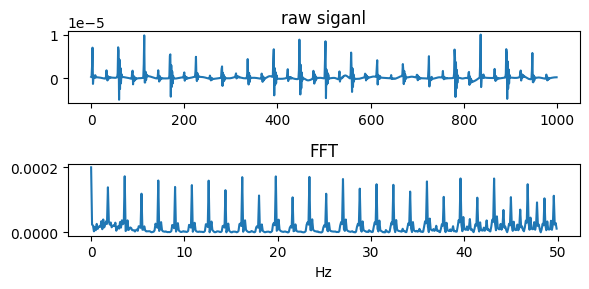

In [22]:
data_ppg = data[1]

# FFT
fs = 100
N = len(data_ppg)
frequencies = np.fft.fftfreq(N, 1/fs)
fft_values = np.fft.fft(data_ppg)
single_sided_spectrum = np.abs(fft_values[:N//2])


plt.figure(figsize=(6, 3))
plt.subplot(2, 1, 1)
plt.plot(data_ppg)
plt.title('raw siganl')

plt.subplot(2, 1, 2)
plt.plot(frequencies[:N//2], single_sided_spectrum)
plt.title('FFT')
plt.xlabel('Hz')

plt.tight_layout()
plt.show()

## Signal preprocessing

In [23]:
""" This is the package responsible for realizing the preprocessment of
photoplethysmogram signals. """

import numpy as np
from scipy import signal
import constants as consts


def preprocess(signal):
    preprocessed_signal = _remove_high_frequency_components(signal)
    preprocessed_signal = _remove_baseline_wander(preprocessed_signal)
    # preprocessed_signal = _upsample(preprocessed_signal)

    return preprocessed_signal


def _remove_high_frequency_components(ppg_signal):
    filter_order = 5
    max_ripple = 0.5
    cut_off_freq_hz = 3
    cut_off_freq_rad_smp = (2 * cut_off_freq_hz) / consts.SAMPLING_FREQ
    low_pass_filtered_signal = np.zeros(len(ppg_signal))

    cheby_num, cheby_den = signal.cheby1(filter_order, max_ripple, cut_off_freq_rad_smp, btype='lowpass')
    low_pass_filtered_signal = signal.filtfilt(cheby_num, cheby_den, ppg_signal)

    return low_pass_filtered_signal

def _remove_low_frequency_components(ppg_signal):
    filter_order = 5
    max_ripple = 0.5
    cut_off_freq_hz = 4
    cut_off_freq_rad_smp = (2 * cut_off_freq_hz) / consts.SAMPLING_FREQ
    high_pass_filtered_signal = np.zeros(len(ppg_signal))

    # 设计高通Chebyshev Type I滤波器
    cheby_num, cheby_den = signal.cheby1(filter_order, max_ripple, cut_off_freq_rad_smp, btype='highpass')
    high_pass_filtered_signal = signal.filtfilt(cheby_num, cheby_den, ppg_signal)

    return high_pass_filtered_signal

def _remove_baseline_wander(ppg_signal):
    signal_length = len(ppg_signal)
    first_window_size = int(np.floor(0.7 * signal_length)+1)
    second_window_size = int(np.floor(0.3 * signal_length)+1)

    mov_median_output = np.zeros(signal_length)
    detrended_signal = np.zeros(signal_length)

    # todo: make sure that window sizes are odd
    mov_median_output = signal.medfilt(ppg_signal, first_window_size)
    mov_median_output = signal.medfilt(mov_median_output, second_window_size)

    detrended_signal = np.subtract(ppg_signal, mov_median_output)

    return detrended_signal


def _upsample(ppg_signal):
    signal_length = len(ppg_signal)
    desired_sampling_freq = 4 * consts.SAMPLING_FREQ

    desired_n_of_samples = int((desired_sampling_freq * signal_length) / (consts.SAMPLING_FREQ))
    upsampled_signal = np.zeros(desired_n_of_samples)
    upsampled_signal = signal.resample(ppg_signal, desired_n_of_samples)

    return upsampled_signal

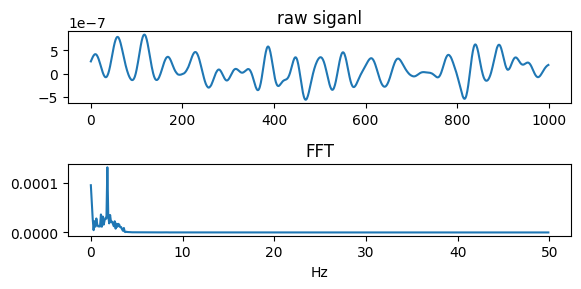

In [25]:
filtered_signal = preprocess(data_ppg)
# filtered_signal = _remove_high_frequency_components(filtered_signal)
# FFT
fs = 100
N = len(filtered_signal)
frequencies = np.fft.fftfreq(N, 1/fs)
fft_values = np.fft.fft(filtered_signal)
single_sided_spectrum = np.abs(fft_values[:N//2])


plt.figure(figsize=(6, 3))
plt.subplot(2, 1, 1)
plt.plot(filtered_signal)
plt.title('raw siganl')

plt.subplot(2, 1, 2)
plt.plot(frequencies[:N//2], single_sided_spectrum)
plt.title('FFT')
plt.xlabel('Hz')

plt.tight_layout()
plt.show()

# Predict S and D by ML Model

Having tried several filtering methods but did not obtain a suitable PPG signal for peak detection. Therefore, it is unsuccessful in extracting the coordinates (X1, Y1, X2, Y2) of S and D as learning features.

Attempted to directly use S and D as labels for supervised training, trained Ridge Regression models for systolic and diastolic pressures, and tested them on the test data. However, the resulting MAE values were 44.54 and 10.21, respectively, while the goal is to achieve MAE <=3.

In [32]:
def calc_mae(gt, pred):
    return np.mean(abs(np.array(gt)-np.array(pred)))

In [35]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

#Import dataset
train_data = np.load('/content/drive/MyDrive/Colab Notebooks/song/simu_20000_0.1_90_140_train.npy')
test_data = np.load('/content/drive/MyDrive/Colab Notebooks/song/simu_10000_0.1_141_178_test.npy')

# For training data
X_train = train_data[:, :1000]
y_train_S = train_data[:, -2]
y_train_D = train_data[:, -1]

# For test data
X_test = test_data[:, :1000]
y_test_S = test_data[:, -2]
y_test_D = test_data[:, -1]

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Reduce to 100 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Ridge Regression models for systolic and diastolic pressures
ridge_systolic = Ridge(alpha=1.0)
ridge_diastolic = Ridge(alpha=1.0)

ridge_systolic.fit(X_train_pca, y_train_S)
ridge_diastolic.fit(X_train_pca, y_train_D)

# prediction of the te4st set
y_predict_systolic = ridge_systolic.predict(X_test_pca)
y_predict_diastolic = ridge_diastolic.predict(X_test_pca)

# Predict on the test set
y_pred_systolic_ridge = ridge_systolic.predict(X_test_pca)
y_pred_diastolic_ridge = ridge_diastolic.predict(X_test_pca)

# Calculate the MAE for both systolic and diastolic predictions
mae_systolic_ridge = mean_absolute_error(y_test_S, y_pred_systolic_ridge)
mae_diastolic_ridge = mean_absolute_error(y_test_D, y_pred_diastolic_ridge)


mae_systolic_ridge, mae_diastolic_ridge

(44.53694704202117, 10.205348634844594)

In [36]:
def plot_2vectors(label, pred, name):
    list1 = label
    list2 = np.array(pred)
    if len(list2.shape) == 2:
        mae = mean_absolute_error(list1, list2[:,0])
    else:
        mae = mean_absolute_error(list1, list2)

    # zipped_lists = zip(list1, list2)
    # sorted_pairs = sorted(zipped_lists)

    # tuples = zip(*sorted_pairs)
    # list1, list2 = np.array([ list(tuple) for tuple in  tuples])

    # print(list1.shape)
    # print(list2.shape)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.figure(figsize=(6, 3))
    plt.clf()
    plt.text(0,np.min(list2),f'MAE={mae}')

    # plt.plot(range(num_rows), list2, label=name + ' prediction')
    plt.scatter(np.arange(list2.shape[0]),list2[sorted_id],s = 1, alpha=0.5,label=f'{name} prediction', color='blue')

    plt.scatter(np.arange(list1.shape[0]),list1[sorted_id],s = 1, alpha=0.5,label=f'{name} label', color='red')

    # plt.plot(range(num_rows), list1, 'r.', label=name + ' label')

    plt.legend()
    plt.savefig(f'{name}.png')
    print(f'Saved plot to {name}.png')
    plt.show()

Saved plot to sp.png


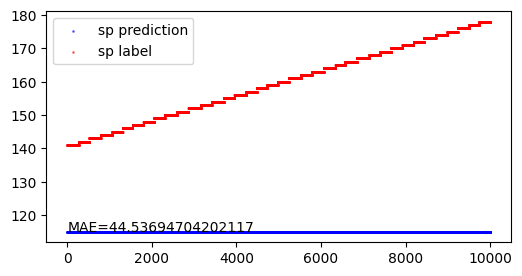

Saved plot to dp.png


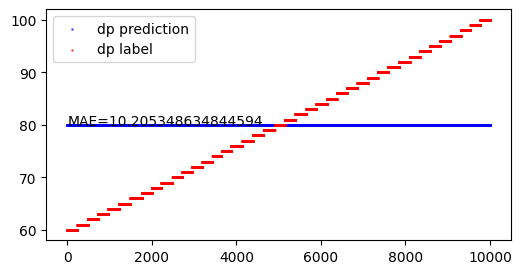

In [37]:
plot_2vectors(y_test_S, y_pred_systolic_ridge, 'sp')
plot_2vectors(y_test_D, y_pred_diastolic_ridge, 'dp')